In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()

%matplotlib notebook


## Original Organics formulation

In [3]:
Wzx = np.matrix('-0.5, 0, 0, 0; \
                -0.3536 -0.3536 0 0; \
                0 0.5 0 0; \
                0.3536 0.3536 0 0;\
                0.5 0 0 0;\
                0.3536 -0.3536 0 0;\
                0 -0.5 0 0; \
                -0.3536 -0.3536 0 0')

Wax = np.matrix('0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1')

Wbx = np.matrix('0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0')

num = np.cos(np.pi / 4)
Wyy = 0.25 * np.matrix([[1, num, 0, -num, -1, -num, 0, num],
                [num, 1, num, 0, -num, -1, -num, 0],
                [0, num, 1, num, 0, -num, -1, -num],
                [-num, 0, num, 1, num, 0, -num, -1],
                [-1, -num, 0, num, 1, num, 0, -num],
                [-num, -1, -num, 0, num, 1, num, 0],
                [0, -num, -1, -num, 0, num, 1, num],
                [num, 0, -num, -1, -num, 0, num, 1]])



Way = 0
Wby = 0
cz = 0
ca = 0
cb = 0
cy = 0

# Time constants in ms
ta = 10 
tb = 10
ty = 10
dt = 10

In [4]:
U,V = np.linalg.eig(Wyy)

<IPython.core.display.Javascript object>


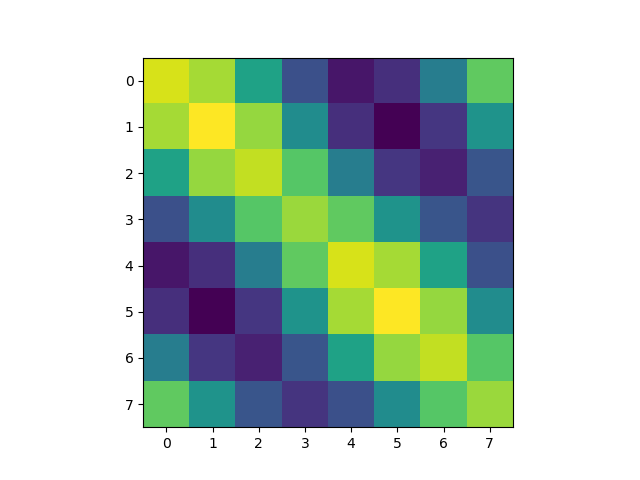

In [5]:
A = V * np.diag(U) * V.T
plt.imshow(A)
plt.show()

In [6]:
posx = [0.0] * 25 + [0.2] * 75 + [0.0] * 300
posy = [0.0] * 25 + [-0.5] * 75 + [0.0] * 300
begin = [1.0] * 75 + [0.0] * 325
delay = [0.0] * 300 + [1.0] * 25 + [0.0] * 75

x_mat = np.matrix([posx, posy, begin, delay])


In [7]:
y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(200):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

<IPython.core.display.Javascript object>


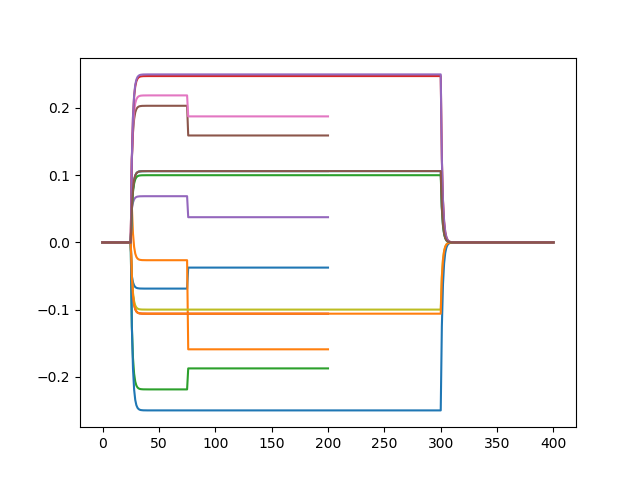

In [8]:
# Plot of Y traces!
plt.figure()
plt.plot(Ymat.T);

## Trying to have Organics maintain a state

Holding can be achieved by setting `Wyy = 1` (identity matrix)

In [9]:
Wyy = 1

y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(400):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

In [10]:
plt.plot(Ymat.T);

## Gating of two-neuron module

In [11]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 2.0}

In [12]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def start_simulation(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * Iref: initial reference current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        * aI: gating variable for I
        * ay: gating variable for y
        * aR: gating variable for Iref
        * z: initial state of z
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    aI_lst, ay_lst, aR_lst: list of gating variables at each instant
    I_lst: list of I activities
    Iref: final reference current state
        
    '''
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    
    
    # Unpack variables
    I, u, v, y, sig, aI = state_init
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    aI_lst = []
    I_lst = []
    
    for i in range(niter):
        # Update of gating variables
        if sig < 1:
            aI = 0.0
        else:
            aI = 1.0
                
        # I update here:
        I += (aI * K * (y - y0)) / tau * dt

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 5)) / tau * dt

        y += (-y + u - v) / 100 * dt

        v_lst.append(v)
        u_lst.append(u)
        y_lst.append(y)
        aI_lst.append(aI)
        I_lst.append(I)
        sig_lst.append(sig)
        
    return u_lst, v_lst, y_lst, aI_lst, I_lst, sig_lst

### Updates from previous meeting

Changes from the previous meeting:

1. Moved threshold y0 to a z-neuron with $z = y - y_0$

2. Removed $I_{ref}$. Previous equation

3. 'Reseting' is implemented by an impulse given to $v$ at the start of the trial



### Description of the current model

At a high level, the simulation alternates between two states which is encoded by a variable `s`. In the setup, `u` and `v` are two neurons that mutually inhibit each other according to this dynamics:

$$ \tau\frac{du}{dt} = -u + \theta \ (W_{uI}I - W_{uv}v)$$

Similarly for $v$,

$$ \tau\frac{dv}{dt} = -v + \theta \ (W_{vI}I - W_{vu}u + I_p)$$

$y$ and $z$ are read-out neurons. $y$ measures the difference between $u$ and $v$ and $z$ measures the deviation of $y$ from the threshold $y_0$.

$$ \tau\frac{dy}{dt} = -y + u - v $$

and for $z$,

$$ \tau\frac{dz}{dt} = -z + y - y_0$$

The global state is given by $s$ which is an external signal. This state alternates between two modes:

* When $s = 0$, the network operates in *integration* mode
    - $v$ receives an impulse $I_p = 5$, for a duration of two time steps. After that $I_p = 0$.
    - $I$ remains constant (gated out, uncoupled from $z$)


* When $s = 1$, the network operates in *update* mode
    - $I_p$ continues to be 0.
    - $I$ gets coupled to $z$.
    
    In particular, $ \tau\frac{dI}{dt} = K(y-y_0)  $


The behavior of $I$ is different in these two different modes. To achieve this, we rely on the gating variables $a_I$, and require that

$$ \tau\frac{dI}{dt} = a_IK(y - y_0) $$


The gating $a_I$ itself can be modeled as a dynamic variable that is linked to the global state $s$.
$$ \frac{da_I}{dt} = \frac{1}{\tau_I}(-a_I + s) $$

The simulation is run below, each state lasts 100 ms.

In [13]:
def plot_simulation(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, min(ulst), max(ulst), where=wherelst, alpha=0.1)
    ax[0].fill_between(np.arange(nsteps) * dt, min(ulst), max(ulst), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, min(vlst), max(vlst), where=wherelst, alpha=0.1)
    ax[1].fill_between(np.arange(nsteps) * dt, min(vlst), max(vlst), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, min(ylst), max(ylst), where=wherelst, alpha=0.1)
    ax[2].fill_between(np.arange(nsteps) * dt, min(ylst), max(ylst), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, min(Ilst), max(Ilst), where=wherelst, alpha=0.1)
    ax[3].fill_between(np.arange(nsteps) * dt, min(Ilst), max(Ilst), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

<IPython.core.display.Javascript object>


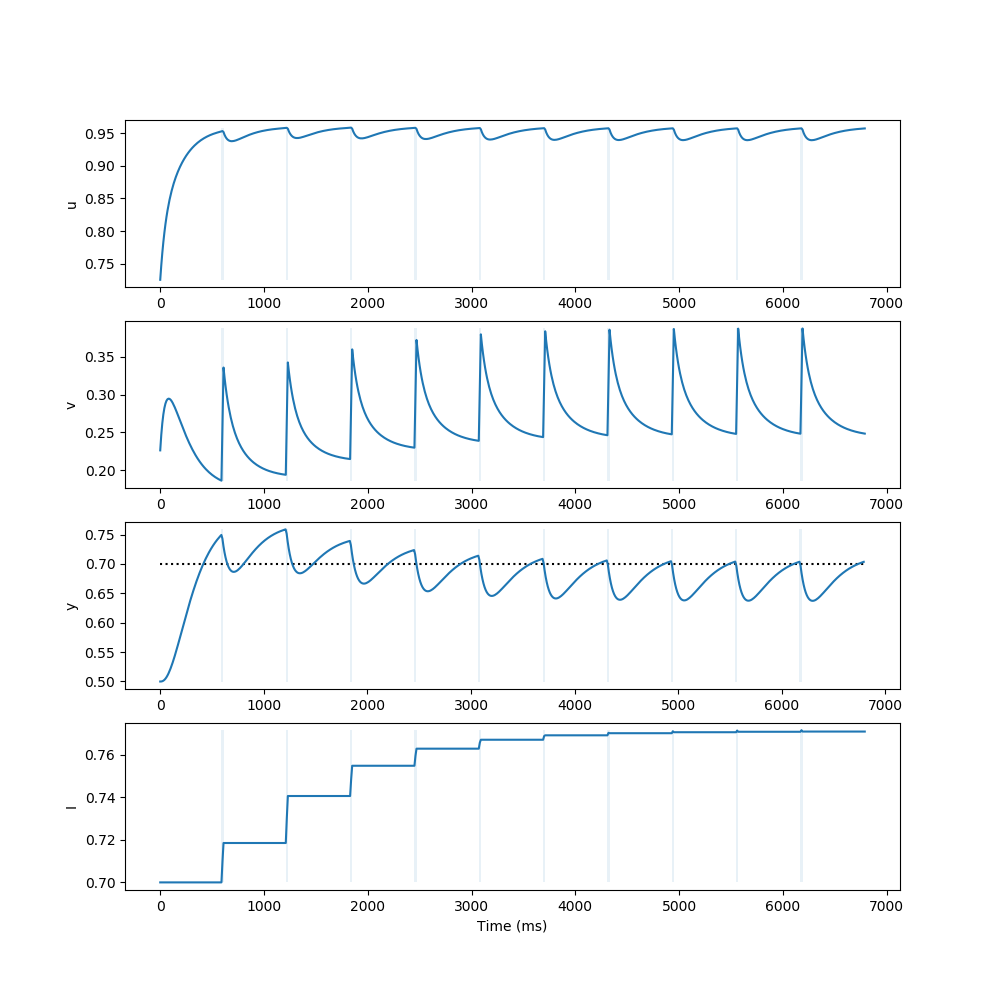

In [16]:
# Initial run
state_init = [0.7, 0.7, 0.2, 0.5, 0.0, 1.0]
ulst, vlst, ylst, aIlst, Ilst, siglst = start_simulation(state_init, PARAMS_DICT, 60)

# For subsequent runs, flip the state every 100 trials
for k in range(20):
    #acoefs = 1 - acoefs
    state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2, \
                 aIlst[-1]]
    if state_init[4] == 0.0:
        ulst2, vlst2, ylst2, aIlst2, Ilst2, siglst2 = start_simulation(state_init, PARAMS_DICT, 60)
    else:
        ulst2, vlst2, ylst2, aIlst2, Ilst2, siglst2 = start_simulation(state_init, PARAMS_DICT, 2)

    ulst += ulst2
    vlst += vlst2
    ylst += ylst2
    aIlst += aIlst2
    Ilst += Ilst2
    siglst += siglst2
plot_simulation(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)